
Processing LINK:
Number of withdrawals: 10
Average withdrawal amount: 858.01 LINK
Average price: $15.35


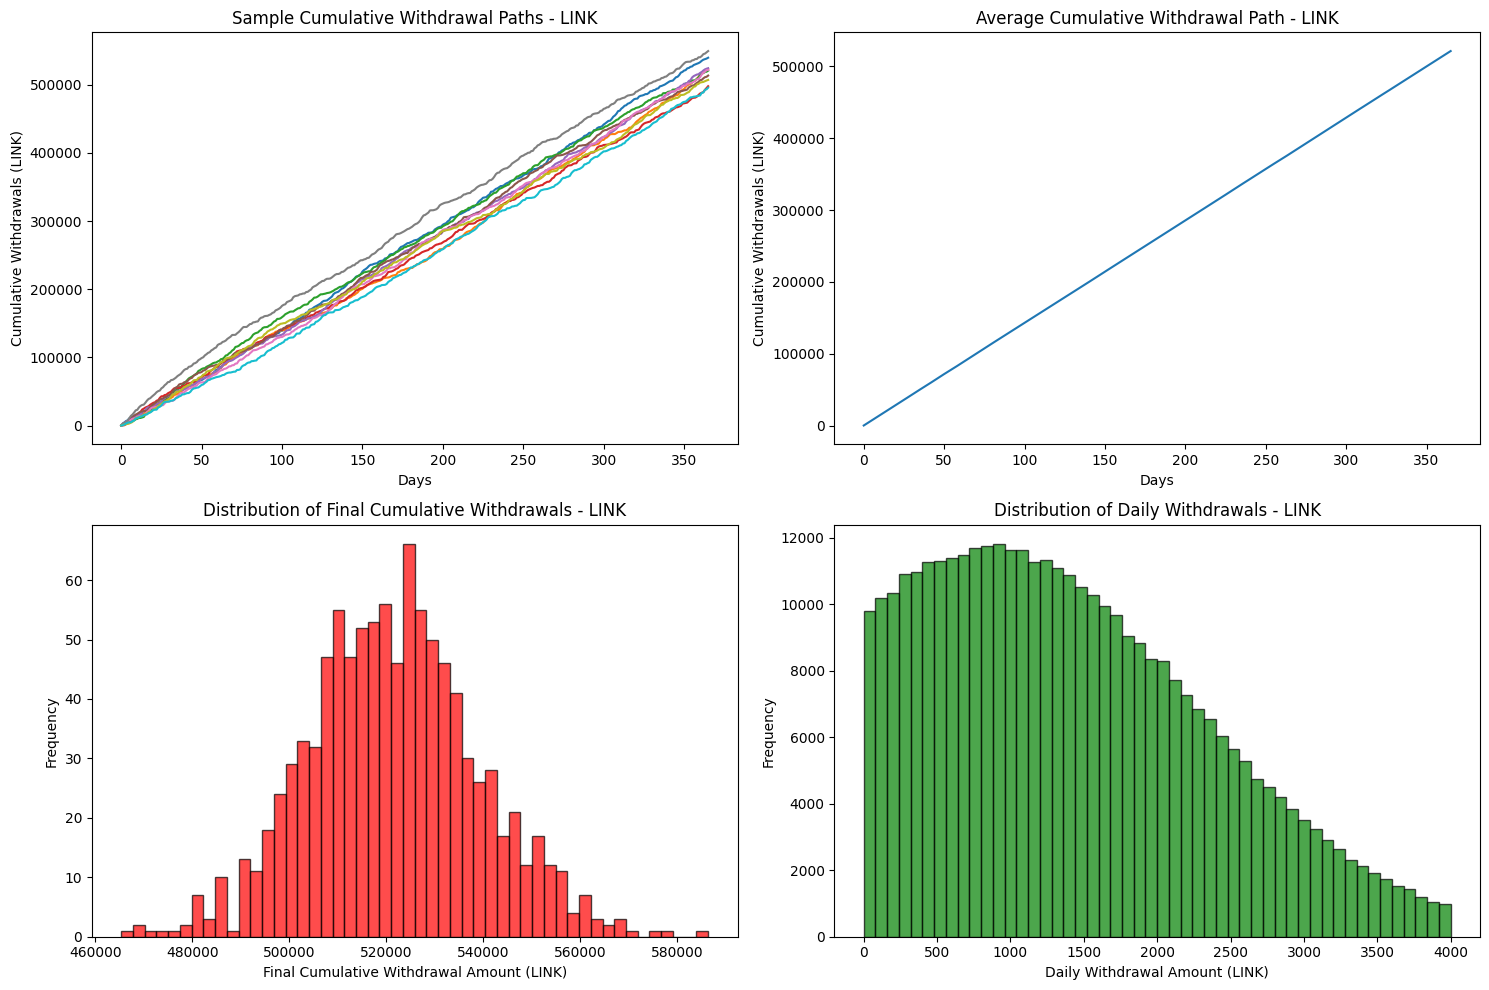

Mean final cumulative withdrawal: 521507.18 LINK
Median final cumulative withdrawal: 521101.41 LINK
5th percentile final cumulative withdrawal: 493661.94 LINK
95th percentile final cumulative withdrawal: 552184.04 LINK

USD Values (based on average price of $15.35):
Mean final cumulative withdrawal: $8005395.16
Median final cumulative withdrawal: $7999166.48
5th percentile final cumulative withdrawal: $7577956.86
95th percentile final cumulative withdrawal: $8476300.31

Processing WETH:
Number of withdrawals: 722
Average withdrawal amount: 5.15 WETH
Average price: $3055.92


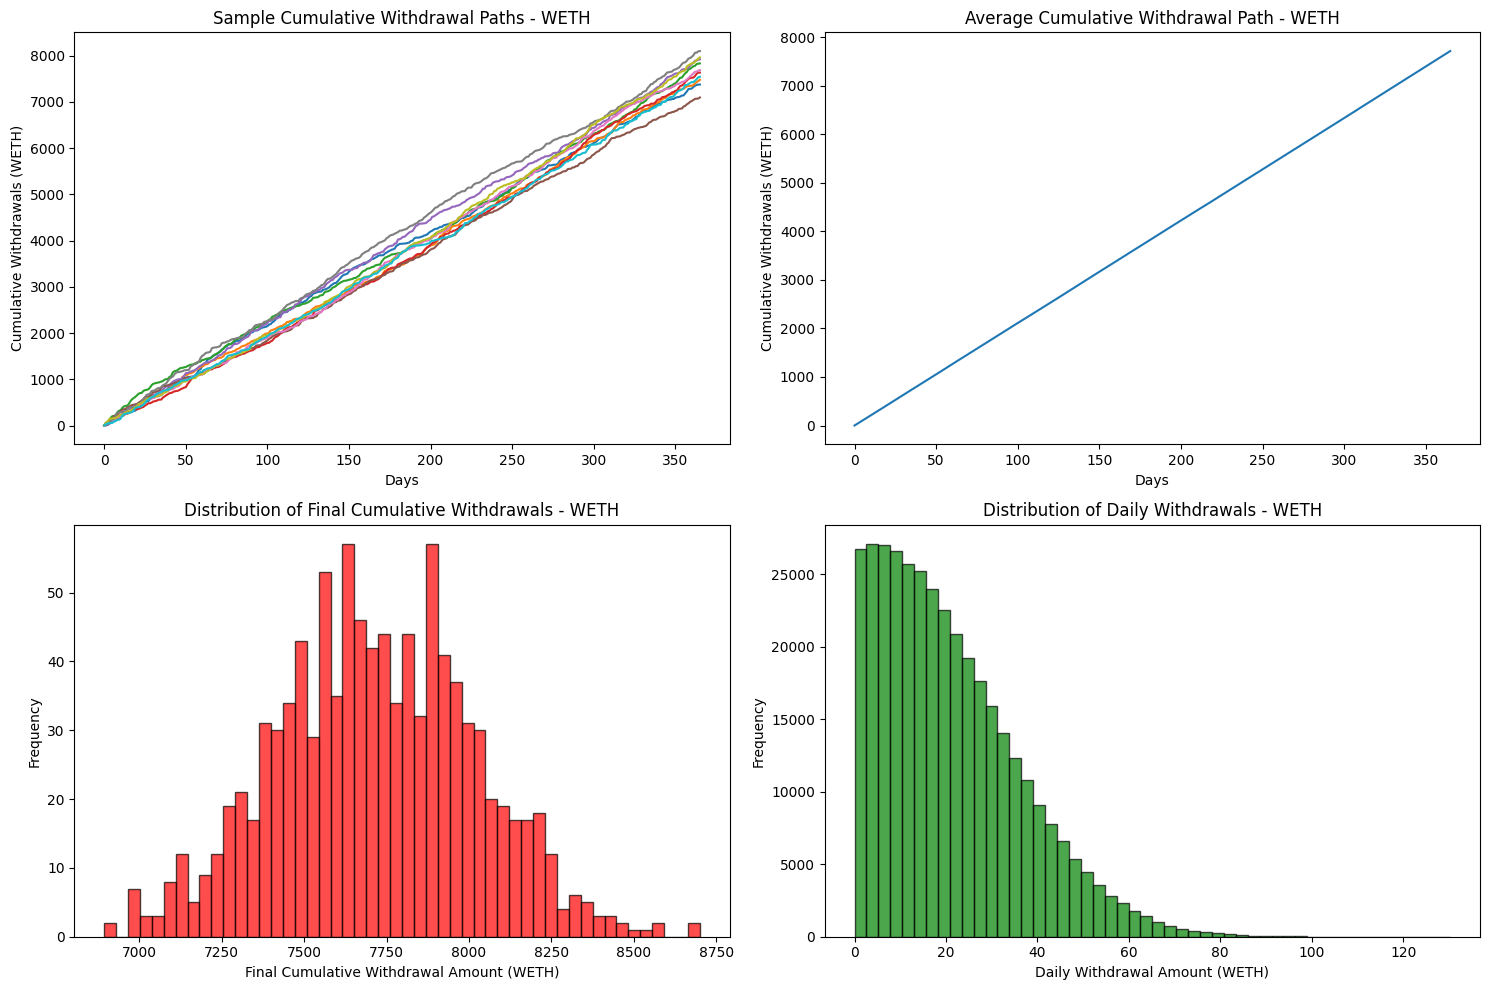

Mean final cumulative withdrawal: 7716.84 WETH
Median final cumulative withdrawal: 7705.88 WETH
5th percentile final cumulative withdrawal: 7224.13 WETH
95th percentile final cumulative withdrawal: 8212.98 WETH

USD Values (based on average price of $3055.92):
Mean final cumulative withdrawal: $23582060.08
Median final cumulative withdrawal: $23548571.14
5th percentile final cumulative withdrawal: $22076383.44
95th percentile final cumulative withdrawal: $25098226.75

Processing USDC:
Number of withdrawals: 396
Average withdrawal amount: 36125.91 USDC
Average price: $1.00


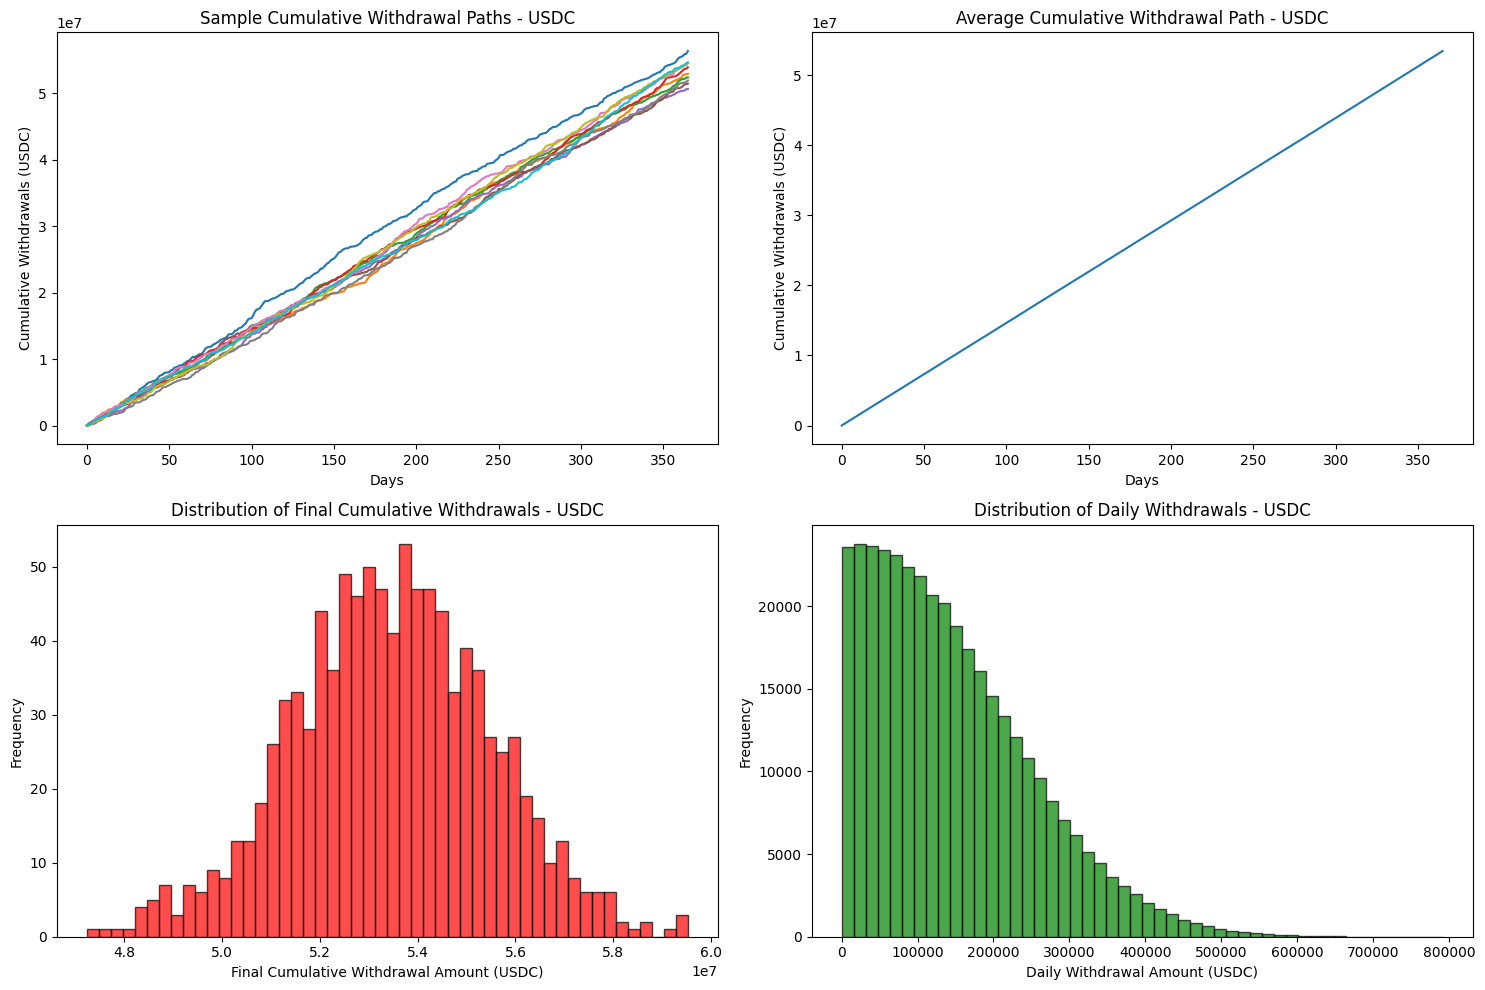

Mean final cumulative withdrawal: 53450848.81 USDC
Median final cumulative withdrawal: 53471768.43 USDC
5th percentile final cumulative withdrawal: 50105700.02 USDC
95th percentile final cumulative withdrawal: 56752779.63 USDC

USD Values (based on average price of $1.00):
Mean final cumulative withdrawal: $53449682.42
Median final cumulative withdrawal: $53470601.59
5th percentile final cumulative withdrawal: $50104606.63
95th percentile final cumulative withdrawal: $56751541.19

Processing DAI:
Number of withdrawals: 58
Average withdrawal amount: 3974.51 DAI
Average price: $1.00


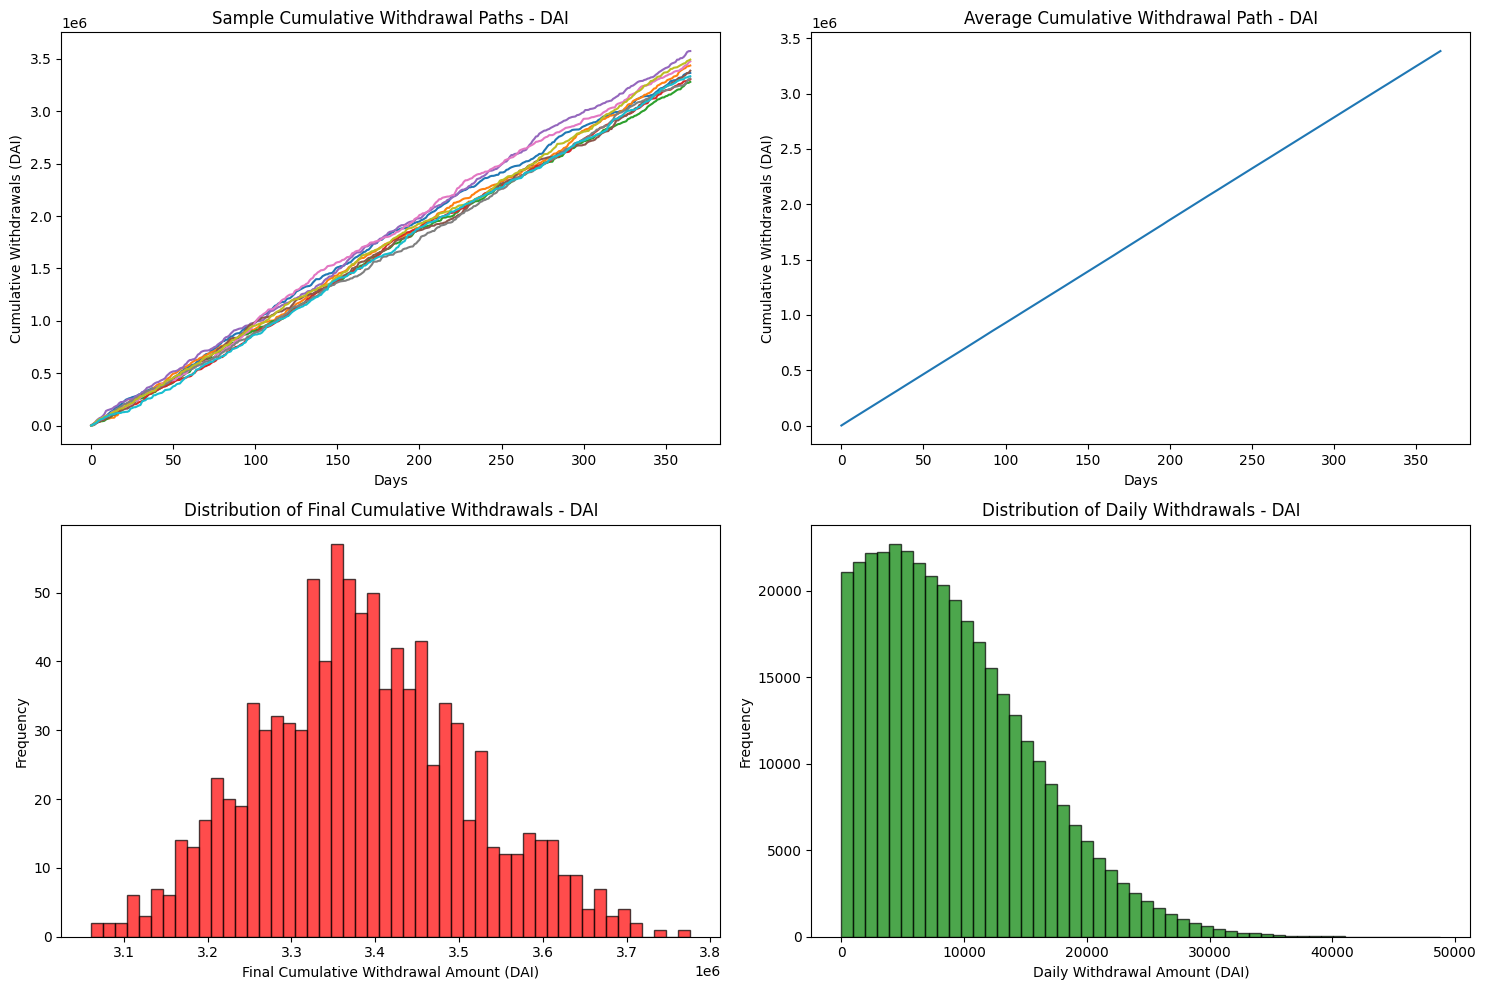

Mean final cumulative withdrawal: 3384541.01 DAI
Median final cumulative withdrawal: 3378369.47 DAI
5th percentile final cumulative withdrawal: 3183526.54 DAI
95th percentile final cumulative withdrawal: 3610370.71 DAI

USD Values (based on average price of $1.00):
Mean final cumulative withdrawal: $3385541.70
Median final cumulative withdrawal: $3379368.34
5th percentile final cumulative withdrawal: $3184467.79
95th percentile final cumulative withdrawal: $3611438.17

Processing USDT:
Number of withdrawals: 157
Average withdrawal amount: 7312.47 USDT
Average price: $1.00


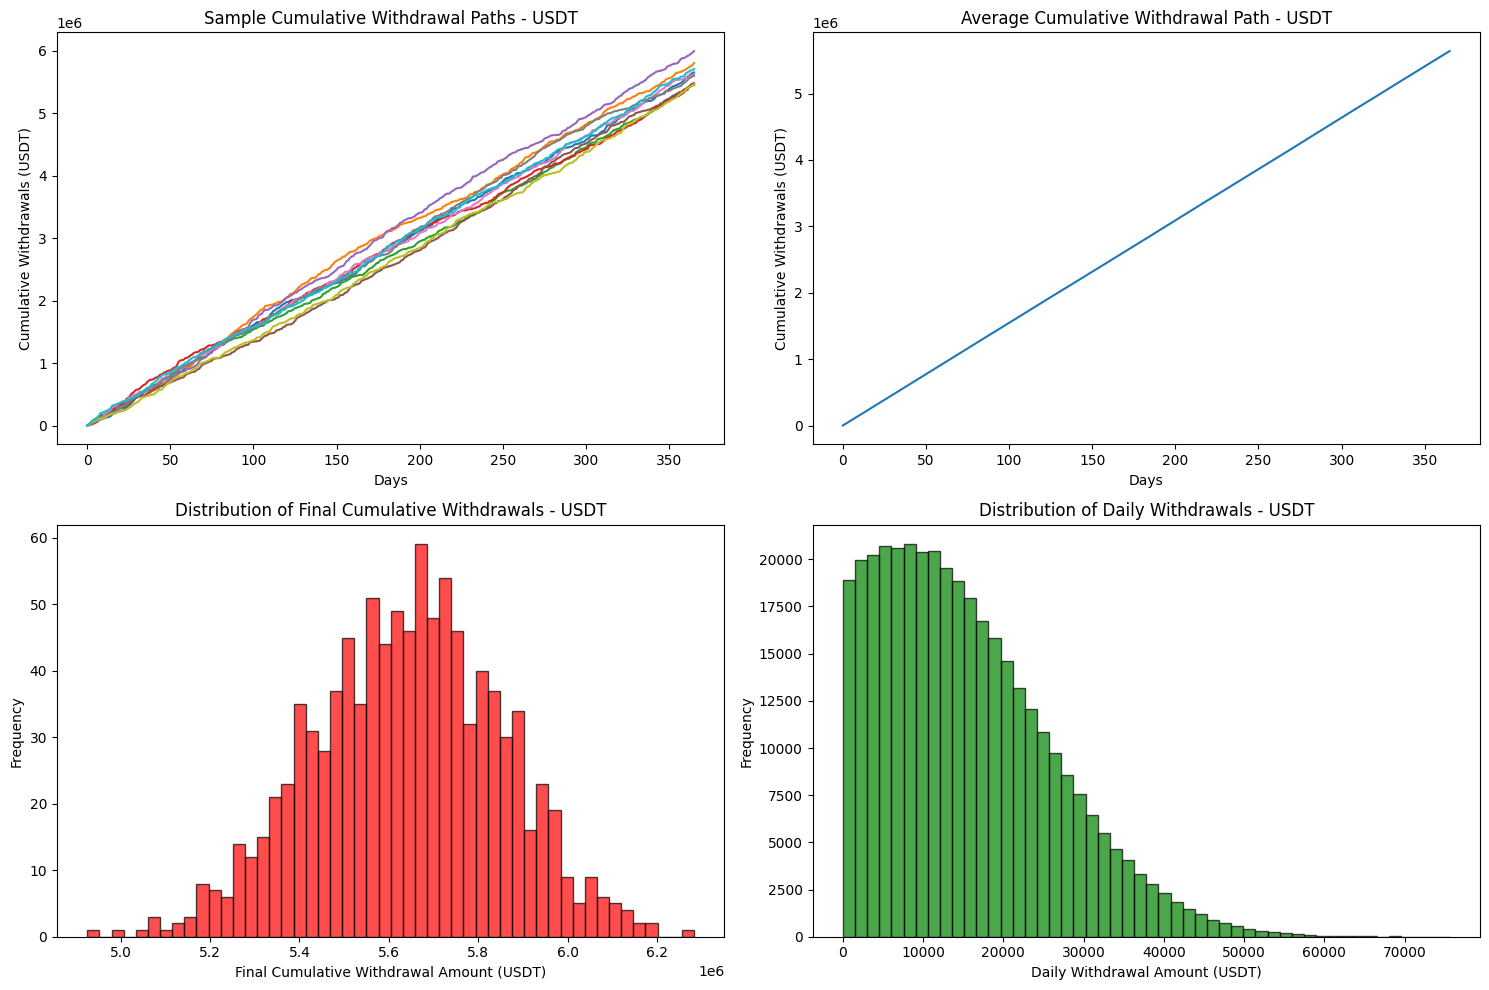

Mean final cumulative withdrawal: 5639535.13 USDT
Median final cumulative withdrawal: 5644522.83 USDT
5th percentile final cumulative withdrawal: 5284012.84 USDT
95th percentile final cumulative withdrawal: 5970527.80 USDT

USD Values (based on average price of $1.00):
Mean final cumulative withdrawal: $5641587.60
Median final cumulative withdrawal: $5646577.12
5th percentile final cumulative withdrawal: $5285935.93
95th percentile final cumulative withdrawal: $5972700.74

Processing WBTC:
Number of withdrawals: 44
Average withdrawal amount: 2.66 WBTC
Average price: $43567.66


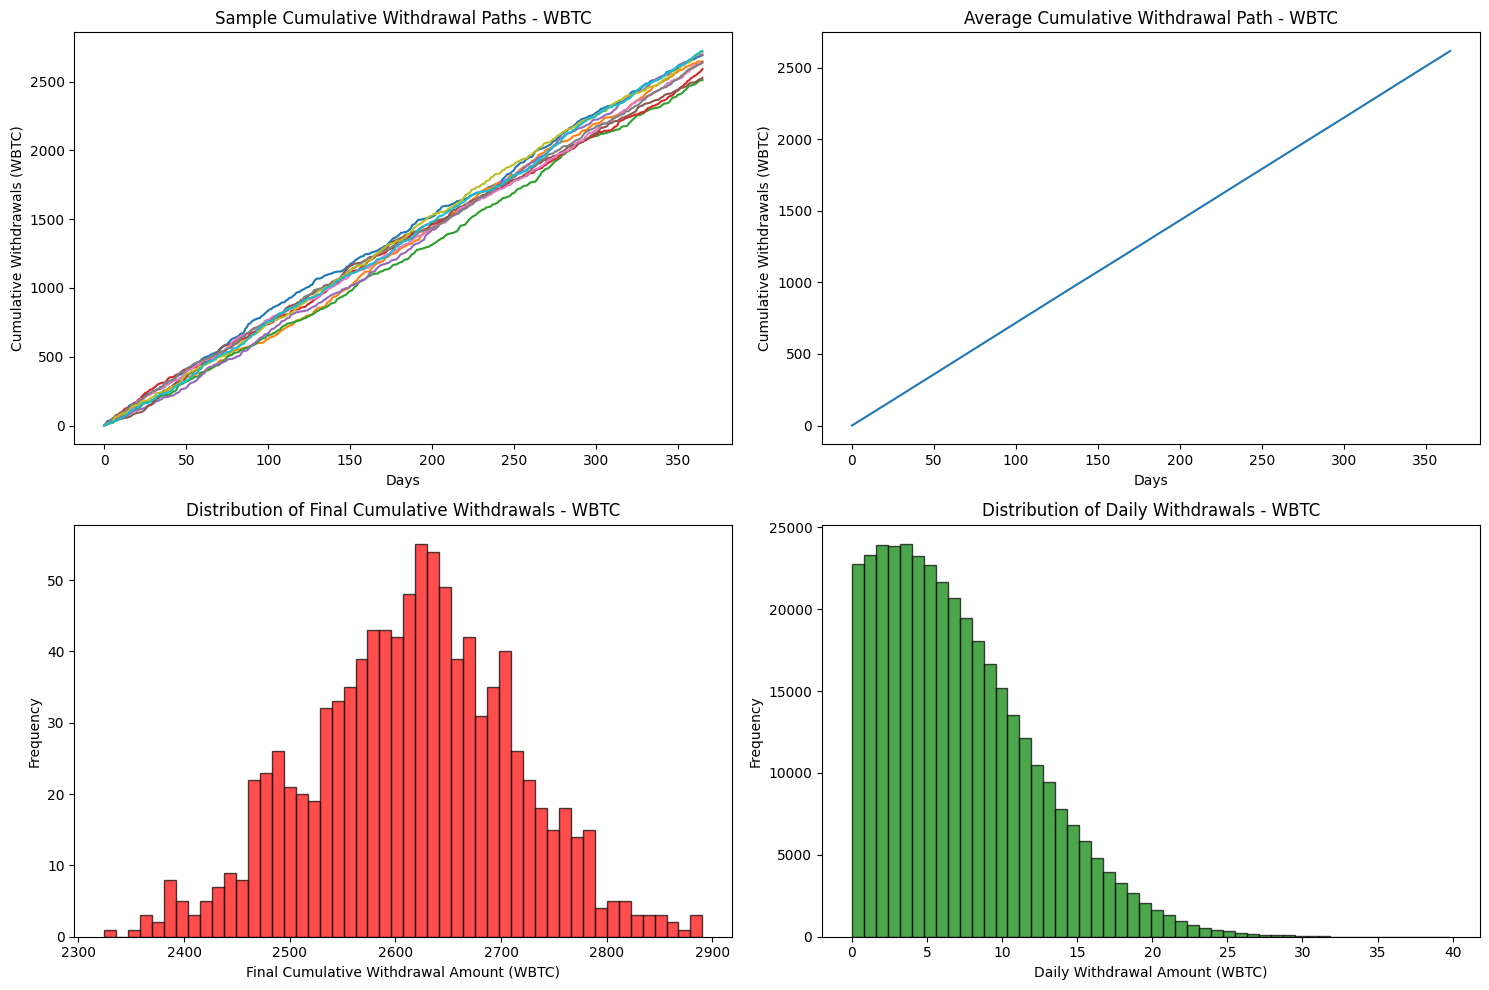

Mean final cumulative withdrawal: 2614.86 WBTC
Median final cumulative withdrawal: 2619.40 WBTC
5th percentile final cumulative withdrawal: 2456.37 WBTC
95th percentile final cumulative withdrawal: 2768.57 WBTC

USD Values (based on average price of $43567.66):
Mean final cumulative withdrawal: $113923303.17
Median final cumulative withdrawal: $114121152.76
5th percentile final cumulative withdrawal: $107018419.02
95th percentile final cumulative withdrawal: $120620242.20

Processing wstETH:
Number of withdrawals: 2
Average withdrawal amount: 1.16 wstETH
Average price: $0.00


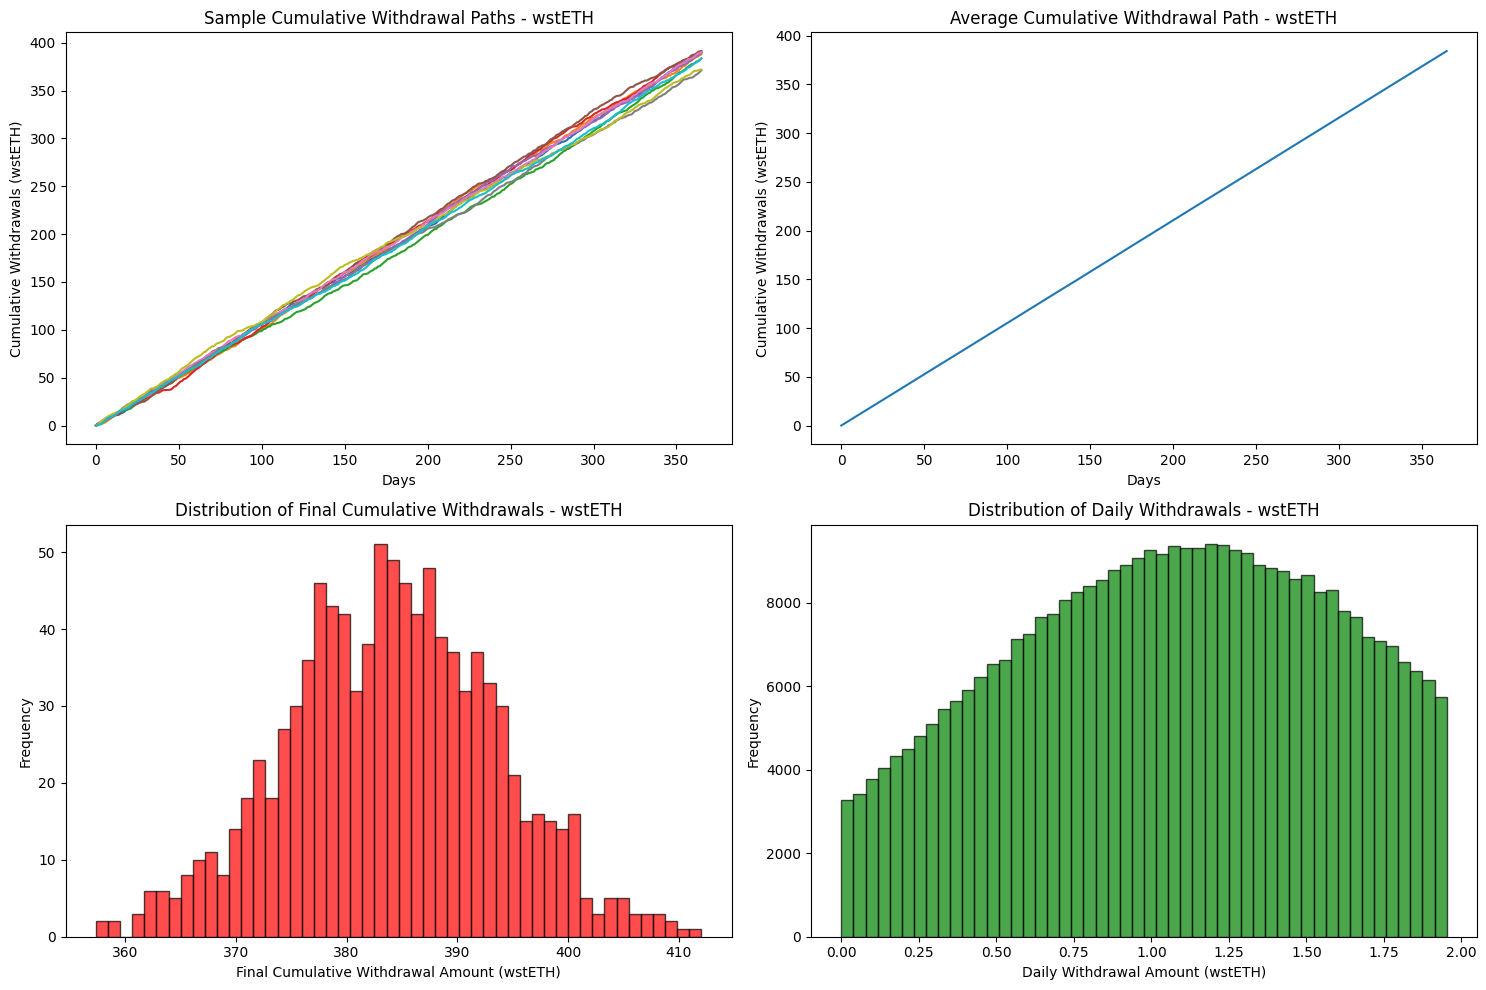

Mean final cumulative withdrawal: 384.05 wstETH
Median final cumulative withdrawal: 384.08 wstETH
5th percentile final cumulative withdrawal: 367.80 wstETH
95th percentile final cumulative withdrawal: 399.76 wstETH

USD Values (based on average price of $0.00):
Mean final cumulative withdrawal: $0.00
Median final cumulative withdrawal: $0.00
5th percentile final cumulative withdrawal: $0.00
95th percentile final cumulative withdrawal: $0.00


In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy import stats

# Read the RedeemUnderlying CSV file
redeem_df = pd.read_csv('ARBITRUMRedeemUnderlying.csv')

# Function to parse the JSON-like string
def parse_json(json_str):
    try:
        data = json.loads(json_str)
        return data.get('symbol', ''), data.get('decimals', 18)
    except:
        return '', 18

# Apply the function to create 'symbol' and 'decimals' columns
redeem_df[['symbol', 'decimals']] = redeem_df.iloc[:, 5].apply(parse_json).tolist()

# Get unique tokens
unique_tokens = redeem_df['symbol'].unique()

def monte_carlo_simulation(withdrawals, num_simulations, time_horizon):
    mean_withdrawal = np.mean(withdrawals)
    std_withdrawal = np.std(withdrawals)
    max_withdrawal = np.max(withdrawals)

    all_paths = []

    for _ in range(num_simulations):
        cumulative_withdrawals = [0]  # Start with 0 withdrawals

        for _ in range(time_horizon):
            if std_withdrawal > 1e-8:
                daily_withdrawal = max(stats.truncnorm(
                    (0 - mean_withdrawal) / std_withdrawal, 
                    (max_withdrawal - mean_withdrawal) / std_withdrawal,
                    loc=mean_withdrawal, 
                    scale=std_withdrawal
                ).rvs(), 0)
            else:
                daily_withdrawal = mean_withdrawal

            cumulative_withdrawals.append(cumulative_withdrawals[-1] + daily_withdrawal)

        all_paths.append(cumulative_withdrawals)

    return all_paths

for token in unique_tokens:
    token_data = redeem_df[(redeem_df['symbol'] == token) & (redeem_df.iloc[:, 1] == 'RedeemUnderlying')]
    
    if token_data.empty:
        print(f"No withdrawal data for {token}. Skipping...")
        continue

    decimals = token_data['decimals'].iloc[0]
    withdrawals = token_data.iloc[:, 2].astype(float).values / (10**decimals)
    prices = token_data.iloc[:, 3].astype(float).values

    print(f"\nProcessing {token}:")
    print(f"Number of withdrawals: {len(withdrawals)}")
    print(f"Average withdrawal amount: {np.mean(withdrawals):.2f} {token}")
    print(f"Average price: ${np.mean(prices):.2f}")

    num_simulations = 1000
    time_horizon = 365  # 1 year

    if len(withdrawals) < 2 or np.std(withdrawals) < 1e-8:
        print(f"Not enough variation in withdrawals for {token}. Skipping Monte Carlo simulation.")
        continue

    all_paths = monte_carlo_simulation(withdrawals, num_simulations, time_horizon)

    plt.figure(figsize=(15, 10))

    # Plot some sample paths
    plt.subplot(2, 2, 1)
    for i in range(min(10, num_simulations)):
        plt.plot(all_paths[i])
    plt.title(f"Sample Cumulative Withdrawal Paths - {token}")
    plt.xlabel("Days")
    plt.ylabel(f"Cumulative Withdrawals ({token})")

    # Plot average path
    plt.subplot(2, 2, 2)
    avg_path = np.mean(all_paths, axis=0)
    plt.plot(avg_path)
    plt.title(f"Average Cumulative Withdrawal Path - {token}")
    plt.xlabel("Days")
    plt.ylabel(f"Cumulative Withdrawals ({token})")

    # Plot distribution of final cumulative withdrawals
    plt.subplot(2, 2, 3)
    final_withdrawals = [path[-1] for path in all_paths]
    plt.hist(final_withdrawals, bins=50, color='red', edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of Final Cumulative Withdrawals - {token}")
    plt.xlabel(f"Final Cumulative Withdrawal Amount ({token})")
    plt.ylabel("Frequency")

    # Plot distribution of daily withdrawals
    plt.subplot(2, 2, 4)
    daily_withdrawals = [path[i+1] - path[i] for path in all_paths for i in range(len(path)-1)]
    plt.hist(daily_withdrawals, bins=50, color='green', edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of Daily Withdrawals - {token}")
    plt.xlabel(f"Daily Withdrawal Amount ({token})")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    print(f"Mean final cumulative withdrawal: {np.mean(final_withdrawals):.2f} {token}")
    print(f"Median final cumulative withdrawal: {np.median(final_withdrawals):.2f} {token}")
    print(f"5th percentile final cumulative withdrawal: {np.percentile(final_withdrawals, 5):.2f} {token}")
    print(f"95th percentile final cumulative withdrawal: {np.percentile(final_withdrawals, 95):.2f} {token}")

    avg_price = np.mean(prices)
    print(f"\nUSD Values (based on average price of ${avg_price:.2f}):")
    print(f"Mean final cumulative withdrawal: ${np.mean(final_withdrawals) * avg_price:.2f}")
    print(f"Median final cumulative withdrawal: ${np.median(final_withdrawals) * avg_price:.2f}")
    print(f"5th percentile final cumulative withdrawal: ${np.percentile(final_withdrawals, 5) * avg_price:.2f}")
    print(f"95th percentile final cumulative withdrawal: ${np.percentile(final_withdrawals, 95) * avg_price:.2f}")